In [77]:
import os, re, shutil, random, csv
from pathlib import Path
from collections import defaultdict, Counter

SRC_PLASTIC   = Path("C:/Users/Miles/Desktop/garbage in sand dataset/Plastic on Sand")   
SRC_BEACH = Path(r"C:/Users/Miles/Desktop/Beach Waste Detection Dataset/Beach_Waste_Dataset") 

SRC_MERGED = Path(r"C:/Users/Miles/Desktop/MoonSand_SRC_merged")

OUT_BASE   = Path("C:/Users/Miles/Desktop/garbage in sand dataset/Plastic on Sand/processed_datasets") # both libraries will be created under here
SAND_OUT_ROOT = OUT_BASE / "sand_regolith"

SPLIT      = (0.75, 0.15, 0.10)         # train/val/test
SEED       = 42
IMG_EXT    = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}
COPY_FILES = True  # True=copy; False=symlink when possible to save disk



In [78]:
def merge_clean_dirt_sources(src_roots, merged_root, copy=True):
    merged_root.mkdir(parents=True, exist_ok=True)

    for cls_name in ("Clean", "Dirt"):
        (merged_root / cls_name).mkdir(parents=True, exist_ok=True)

    for root in src_roots:
        for cls_name in ("Clean", "Dirt"):
            src_dir = root / cls_name
            if not src_dir.exists():
                print(f"WARNING: {src_dir} does not exist, skipping")
                continue

            for img in src_dir.iterdir():
                if not (img.is_file() and img.suffix.lower() in IMG_EXT):
                    continue

                # prefix by dataset name to avoid filename clashes
                dest_name = f"{root.name}_{img.name}"
                dest = merged_root / cls_name / dest_name

                if copy:
                    shutil.copy2(img, dest)
                else:
                    # symlink if you prefer (Windows needs admin or dev mode)
                    if not dest.exists():
                        os.symlink(img, dest)

    print("Merged source built at:", merged_root)



In [79]:
merge_clean_dirt_sources([SRC_PLASTIC, SRC_BEACH], SRC_MERGED, copy=True)


Merged source built at: C:\Users\Miles\Desktop\MoonSand_SRC_merged


In [85]:


SPLIT = (0.75, 0.15, 0.10)
SEED = 42

build_sand_dataset(
    src_root=SRC_MERGED,
    out_root=SAND_OUT_ROOT,
    split=SPLIT
)

SAND_DATA = SAND_OUT_ROOT



Dataset built at: C:\Users\Miles\Desktop\garbage in sand dataset\Plastic on Sand\processed_datasets\sand_regolith


In [86]:
print("train:", [d.name for d in (SAND_DATA / "images" / "train").iterdir() if d.is_dir()])
print("val:  ", [d.name for d in (SAND_DATA / "images" / "val").iterdir() if d.is_dir()])
print("test: ", [d.name for d in (SAND_DATA / "images" / "test").iterdir() if d.is_dir()])


train: ['Clean', 'Dirt']
val:   ['Clean', 'Dirt']
test:  ['Clean', 'Dirt']


In [87]:
from ultralytics import YOLO
from pathlib import Path
import torch, os
print("Torch:", torch.__version__, "CUDA:", torch.cuda.is_available())

Torch: 2.9.0+cpu CUDA: False


In [88]:
def build_sand_dataset(src_root=SRC_ROOT, out_root=OUT_BASE, split=SPLIT):
    random.seed(SEED)
    classes = [d for d in src_root.iterdir() if d.is_dir()]
    assert classes, f"No class folders found in {src_root}"

    # Create target folders: images/train|val|test/<class_name>
    for sp in ("train", "val", "test"):
        for c in classes:
            (out_root / "images" / sp / c.name).mkdir(parents=True, exist_ok=True)

    for c in classes:
        files = [p for p in c.iterdir() if p.suffix.lower() in IMG_EXT]
        if not files:
            print(f"WARNING: no images in {c}")
            continue

        random.shuffle(files)
        n = len(files)
        n_train = int(split[0] * n)
        n_val   = int(split[1] * n)
        # remaining go to test
        splits = {
            "train": files[:n_train],
            "val":   files[n_train:n_train + n_val],
            "test":  files[n_train + n_val:],
        }

        for sp, fps in splits.items():
            for src in fps:
                dst = out_root / "images" / sp / c.name / src.name
                if COPY_FILES:
                    shutil.copy2(src, dst)
                else:
                    if not dst.exists():
                        os.symlink(src, dst)

    print("Dataset built at:", out_root)




In [89]:
from ultralytics import YOLO
from pathlib import Path
import torch, os

print("Torch:", torch.__version__, "CUDA:", torch.cuda.is_available())

SAND_DATA = OUT_BASE  # just an alias so code reads nicely



Torch: 2.9.0+cpu CUDA: False


In [90]:
sand_model = YOLO("yolov8n-cls.pt")   # or yolov8s-cls.pt if VRAM is fine

sand_results = sand_model.train(
    data=str(SAND_DATA / "images"),   # images/train, images/val, images/test
    epochs=30,
    imgsz=224,
    batch=32,
    lr0=1e-3,

    # --- augmentations (classification supports these) ---
    scale=0.25,        # random zoom in/out ~±25%
    fliplr=0.5,        # 50% chance horizontal flip
    flipud=0.3,        # 30% chance vertical flip
    erasing=0.3,       # random erasing patches (simulates small occlusions)
    hsv_h=0.0,         # keep hue fixed (regolith is mostly neutral)
    hsv_s=0.3,         # small saturation jitter
    hsv_v=0.3,         # brightness jitter (simulate different lighting)
    auto_augment="randaugment",  # extra mild geometric/photometric aug
    # -----------------------------------------------------
    
    project="runs_cls",
    name="sand_clean_vs_dirt_aug",
    patience=10,
    verbose=True
)


New https://pypi.org/project/ultralytics/8.3.230 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.227  Python-3.11.5 torch-2.9.0+cpu CPU (AMD Ryzen 9 5900HX with Radeon Graphics)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\Miles\Desktop\garbage in sand dataset\Plastic on Sand\processed_datasets\images, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.3, exist_ok=False, fliplr=0.5, flipud=0.3, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.3, hsv_v=0.3, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-cls.pt, momentum=0.93

In [7]:
"""
sand_model = YOLO("yolov8n-cls.pt")   # or "yolov8s-cls.pt" if VRAM allows

sand_results = sand_model.train(
    data=str(SAND_DATA / "images"),   # must contain train/, val/, test/
    epochs=20,
    imgsz=224,
    lr0=1e-3,
    batch=32,
    patience=10,
    project="runs_cls",
    name="sand_clean_vs_dirt",
    verbose=True
)
"""


'\nsand_model = YOLO("yolov8n-cls.pt")   # or "yolov8s-cls.pt" if VRAM allows\n\nsand_results = sand_model.train(\n    data=str(SAND_DATA / "images"),   # must contain train/, val/, test/\n    epochs=20,\n    imgsz=224,\n    lr0=1e-3,\n    batch=32,\n    patience=10,\n    project="runs_cls",\n    name="sand_clean_vs_dirt",\n    verbose=True\n)\n'

In [8]:
"""
evaluation helper
"""

'\nevaluation helper\n'

In [91]:
import shutil
shutil.rmtree(SAND_DATA / "images" / "train" / "processed_datasets", ignore_errors=True)
shutil.rmtree(SAND_DATA / "images" / "val"   / "processed_datasets", ignore_errors=True)
shutil.rmtree(SAND_DATA / "images" / "test"  / "processed_datasets", ignore_errors=True)


In [92]:
# YOLOv8 classification evaluation WITHOUT scikit-learn
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
import csv

IMG_EXT = {".jpg",".jpeg",".png",".bmp",".tif",".tiff"}

def eval_cls_dataset_nosk(model, dataset_root: Path, split="test", imgsz=224, batch=64, save_dir=None, topk=(1,5)):
    root = Path(dataset_root)
    split_dir = root / "images" / split
    assert split_dir.exists(), f"Missing split folder: {split_dir}"

    # Collect files and ground-truth (folder name = label)
    class_names = sorted([d.name for d in split_dir.iterdir() if d.is_dir()])
    name_to_id = {n:i for i,n in enumerate(class_names)}
    files, y_true = [], []
    for cls in class_names:
        for p in (split_dir/cls).rglob("*"):
            if p.suffix.lower() in IMG_EXT and p.is_file():
                files.append(str(p))
                y_true.append(name_to_id[cls])
    y_true = np.array(y_true, dtype=int)
    assert len(files) > 0, f"No images under {split_dir}"

    # Predict
    res = model.predict(source=files, imgsz=imgsz, batch=batch, verbose=False)
    y_pred = np.array([int(r.probs.top1) for r in res], dtype=int)

    # Confusion matrix
    nC = len(class_names)
    cm = np.zeros((nC, nC), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1

    # Overall accuracy
    acc = (y_true == y_pred).mean()

    # Per-class metrics (precision/recall/F1/support)
    support = cm.sum(axis=1)
    tp = np.diag(cm).astype(float)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp
    precision = np.divide(tp, tp + fp, out=np.zeros_like(tp), where=(tp+fp)!=0)
    recall    = np.divide(tp, tp + fn, out=np.zeros_like(tp), where=(tp+fn)!=0)
    f1        = np.divide(2*precision*recall, precision+recall, out=np.zeros_like(tp), where=(precision+recall)!=0)

    # Top-k accuracy (optional)
    topk_acc = {}
    for k in topk:
        # get top-k indices for each prediction
        topk_ok = 0
        for r, yt in zip(res, y_true):
            # r.probs.top5 exists for k<=5; otherwise fall back to argsort
            if hasattr(r.probs, "top5") and k <= 5:
                idx = list(map(int, r.probs.top5[:k]))
            else:
                probs = r.probs.data.cpu().numpy()
                idx = np.argsort(-probs)[:k].tolist()
            if yt in idx:
                topk_ok += 1
        topk_acc[k] = topk_ok / len(y_true)

    # Save dir
    if save_dir is None:
        save_dir = Path("runs") / "classify_reports" / (root.name + f"_{split}")
    save_dir.mkdir(parents=True, exist_ok=True)

    # Plot confusion matrix (counts and normalized)
    def plot_cm(M, labels, normalize=False, fname="cm.png"):
        A = M.astype(float)
        if normalize:
            row_sums = A.sum(axis=1, keepdims=True) + 1e-12
            A = A / row_sums
        fig, ax = plt.subplots(figsize=(max(6, 0.8*len(labels)), max(5, 0.8*len(labels))))
        im = ax.imshow(A)
        ax.figure.colorbar(im, ax=ax)
        ax.set_xticks(range(len(labels))); ax.set_yticks(range(len(labels)))
        ax.set_xticklabels(labels, rotation=45, ha="right"); ax.set_yticklabels(labels)
        ax.set_xlabel("Predicted"); ax.set_ylabel("True")
        ax.set_title(("Normalized " if normalize else "") + "Confusion Matrix")
        if len(labels) <= 20:  # annotate if not huge
            thresh = A.max() / 2
            for i in range(A.shape[0]):
                for j in range(A.shape[1]):
                    txt = f"{A[i,j]:.2f}" if normalize else f"{int(M[i,j])}"
                    ax.text(j, i, txt, ha="center", va="center",
                            color="white" if A[i,j] > thresh else "black", fontsize=8)
        fig.tight_layout()
        fig.savefig(save_dir/fname, dpi=180, bbox_inches="tight")
        plt.show()

    plot_cm(cm, class_names, normalize=False, fname="confusion_matrix_counts.png")
    plot_cm(cm, class_names, normalize=True,  fname="confusion_matrix_normalized.png")

    # Per-class F1 bar chart
    fig, ax = plt.subplots(figsize=(max(6, 0.5*len(class_names)), 4))
    ax.bar(range(len(class_names)), f1)
    ax.set_xticks(range(len(class_names))); ax.set_xticklabels(class_names, rotation=45, ha="right")
    ax.set_ylabel("F1-score"); ax.set_title("Per-class F1")
    fig.tight_layout()
    fig.savefig(save_dir/"per_class_f1.png", dpi=180, bbox_inches="tight")
    plt.show()

    # CSV report
    with open(save_dir/"classification_report.csv","w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow(["class","precision","recall","f1_score","support"])
        for i, name in enumerate(class_names):
            w.writerow([name, float(precision[i]), float(recall[i]), float(f1[i]), int(support[i])])
        w.writerow([])
        w.writerow(["accuracy", float(acc), "", "", int(support.sum())])

    print(f"Saved reports to: {save_dir}")
    print(f"Top-1 acc: {acc:.4f}  " + "  ".join([f"top-{k}: {topk_acc[k]:.4f}" for k in topk]))
    return {"acc": acc, "topk": topk_acc, "classes": class_names, "cm": cm, 
            "precision": precision, "recall": recall, "f1": f1, "support": support, "save_dir": save_dir}


In [93]:
print("Classes I see in test split:")
print(sorted([d.name for d in (SAND_DATA / "images" / "test").iterdir() if d.is_dir()]))


Classes I see in test split:
['Clean', 'Dirt']


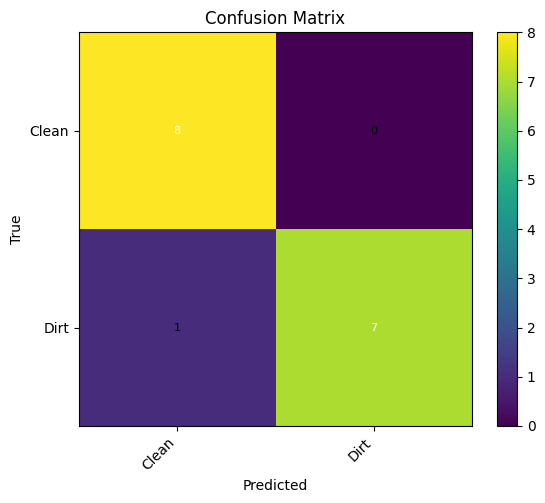

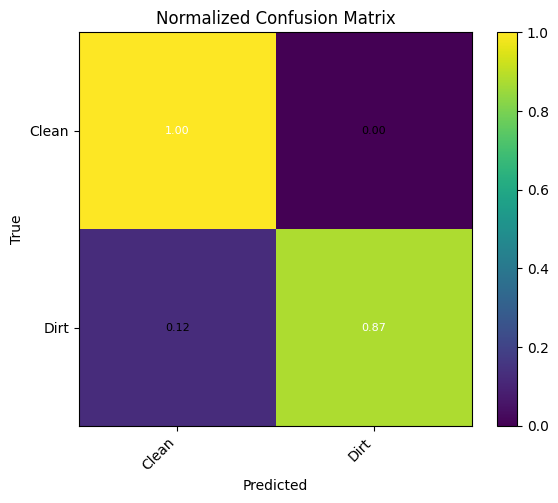

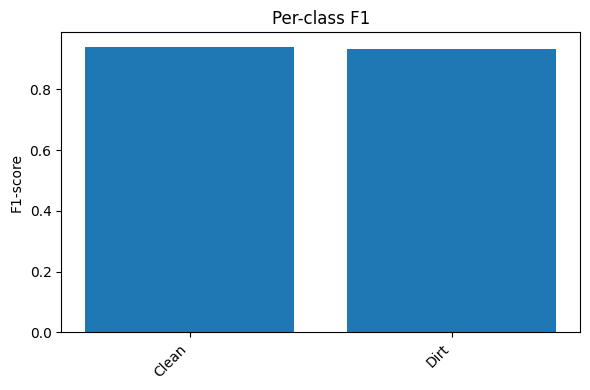

Saved reports to: runs\classify_reports\processed_datasets_test
Top-1 acc: 0.9375  top-1: 0.9375  top-5: 1.0000


In [94]:
SandEval = eval_cls_dataset_nosk(
    model=sand_model,
    dataset_root=SAND_DATA,
    split="test",    # or "val"
    imgsz=224,
    batch=32
)


In [95]:
"""
Simple “is this patch good harvesting sand?” function

"""

'\nSimple “is this patch good harvesting sand?” function\n\n'

In [96]:
from pathlib import Path

# name of the "good" class must match your folder exactly
GOOD_CLASS_NAME = "Clean"

def classify_patch(image_path, model=sand_model, prob_threshold=0.8):
    """
    Returns:
        {
          'pred_class': 'Clean' or 'Dirt',
          'pred_conf': float,
          'is_good_sand': bool
        }
    """
    image_path = Path(image_path)
    res = model.predict(str(image_path), imgsz=224, verbose=False)[0]
    probs = res.probs
    class_id = int(probs.top1)
    pred_name = res.names[class_id]
    pred_conf = float(probs.top1conf)

    is_good = (pred_name == GOOD_CLASS_NAME) and (pred_conf >= prob_threshold)

    return {
        "pred_class": pred_name,
        "pred_conf": pred_conf,
        "is_good_sand": is_good,
    }

# quick sanity check on a test image
example_img = next((SAND_DATA / "images" / "test" / GOOD_CLASS_NAME).glob("*.*"))
classify_patch(example_img)


{'pred_class': 'Clean', 'pred_conf': 0.9905417561531067, 'is_good_sand': True}

In [13]:
#Using both models together (prototype decision layer)

In [54]:
#Define actions + simple mission reward

#Actions: 0=approach, 1=bypass, 2=sample.

"""Reward (edit to our mission):

“valuable” definition + reward """

'Reward (edit to our mission):\n\n“valuable” definition + reward '

In [97]:
# --- Configure what "valuable" means for now ---
# --- Configure what "valuable" means for sand harvesting ---
# This must match your folder / class name in the dataset
HARVESTABLE_CLASS = "Clean"          # "clean sand, no big objects"
NON_HARVESTABLE_CLASS = "Dirt"       # anything with plastic/rocks/etc.

ACTIONS = ["approach", "bypass", "sample"]  # 0,1,2


def is_valuable(class_name: str) -> bool:
    """
    For the new setup, 'valuable' means the patch is clean regolith
    (i.e., belongs to the HARVESTABLE_CLASS).
    """
    return class_name == HARVESTABLE_CLASS


def reward_fn(gt_clean: bool, action: int) -> float:
    """
    Simple reward scheme:
    - If the ground truth patch is clean, reward 'sample' (2).
    - If the ground truth patch is dirty, reward 'bypass' (1).
    - All other (action, label) combos give 0.
    """
    if gt_clean:
        # best behavior: sample clean regolith
        return 1.0 if action == 2 else 0.0
    else:
        # best behavior: bypass dirty/contaminated patches
        return 1.0 if action == 1 else 0.0



In [16]:
""" 
Context features + ε-greedy bandit


tiny linear model per action: Q_a(x) = w_a · x. Features include:

one-hot rock type (3)

confidence bin (low/high)

distance bin (near/far)

(optional) one-hot mineral for top-K frequent minerals
"""

' \nContext features + ε-greedy bandit\n\n\ntiny linear model per action: Q_a(x) = w_a · x. Features include:\n\none-hot rock type (3)\n\nconfidence bin (low/high)\n\ndistance bin (near/far)\n\n(optional) one-hot mineral for top-K frequent minerals\n'

In [98]:
class EpsGreedyBandit:
    def __init__(self, n_actions, context_dim, eps=0.1, lr=0.1):
        self.eps = eps
        self.lr = lr
        self.W = np.zeros((n_actions, context_dim), dtype=np.float32)

    def select(self, x):
        if np.random.rand() < self.eps:
            return np.random.randint(self.W.shape[0])
        q = self.W @ x
        return int(np.argmax(q))

    def update(self, x, a, r):
        pred = float(self.W[a] @ x)
        self.W[a] += self.lr * (r - pred) * x

def discretize_conf(p):   # 0..1
    return 1 if p >= 0.8 else 0

def discretize_dist(m):
    return 0 if m < 2.0 else 1  # <2m = near

In [99]:
"""
streaming from dataset (RockType + optional Mineral)

"""

'\nstreaming from dataset (RockType + optional Mineral)\n\n'

In [100]:
# pick which split to simulate with
SPLIT = "test"  # or "val"

IMG_EXT = {".jpg",".jpeg",".png",".bmp",".tif",".tiff"}

def iter_dataset_files(dataset_root: Path, split="test"):
    split_dir = dataset_root/"images"/split
    classes = sorted([d.name for d in split_dir.iterdir() if d.is_dir()])
    for cls in classes:
        for p in (split_dir/cls).rglob("*"):
            if p.suffix.lower() in IMG_EXT and p.is_file():
                yield str(p), cls


In [101]:
def make_features(cls_name, cls_conf, distance_m, class_to_id):
    """
    Features for the bandit:
    - One-hot predicted class (e.g., Clean vs Dirt)
    - Discretized confidence (high / low)
    - Discretized distance (near / far)
    """
    # one-hot class
    f_cls = np.zeros(len(class_to_id), dtype=np.float32)
    f_cls[class_to_id[cls_name]] = 1.0

    # conf bin (2)
    f_conf = np.zeros(2, dtype=np.float32)
    f_conf[discretize_conf(cls_conf)] = 1.0

    # distance bin (2)
    f_dist = np.zeros(2, dtype=np.float32)
    f_dist[discretize_dist(distance_m)] = 1.0

    return np.concatenate([f_cls, f_conf, f_dist], axis=0)

In [21]:
"""environmental validation"""

'environmental validation'

In [102]:
# build class_to_id from your trained model or dataset structure
class_to_id = {name: i for i, name in enumerate(sorted([HARVESTABLE_CLASS, NON_HARVESTABLE_CLASS]))}
context_dim = len(class_to_id) + 2 + 2
bandit = EpsGreedyBandit(n_actions=len(ACTIONS), context_dim=context_dim, eps=0.1, lr=0.1)

for img_path, gt_class in iter_dataset_files(SAND_DATA, split=SPLIT):
    # run classifier
    res = sand_model.predict(img_path, imgsz=224, verbose=False)[0]
    probs = res.probs
    pred_id = int(probs.top1)
    pred_name = res.names[pred_id]
    pred_conf = float(probs.top1conf)

    # fake distance for now, or plug in real sensor estimate
    distance_m = np.random.uniform(0.5, 4.0)

    x = make_features(pred_name, pred_conf, distance_m, class_to_id)
    a = bandit.select(x)

    gt_clean = (gt_class == HARVESTABLE_CLASS)
    r = reward_fn(gt_clean, a)

    bandit.update(x, a, r)


In [23]:
"""
Rover-pose based distance (simulated, but drop-in replaceable)


"""

'\nRover-pose based distance (simulated, but drop-in replaceable)\n\n\n'

In [103]:
import numpy as np
import math

def simulate_rover_pose(prev_pose=None, max_step=0.4):
    """
    Simple 2D rover motion model: random walk in x–y.
    In ROS later, you’ll replace this with real pose from TF (/base_link).
    """
    if prev_pose is None:
        return np.array([0.0, 0.0], dtype=np.float32)

    angle = np.random.uniform(-math.pi/4, math.pi/4)
    step  = np.random.uniform(0.0, max_step)
    dx = step * math.cos(angle)
    dy = step * math.sin(angle)
    return prev_pose + np.array([dx, dy], dtype=np.float32)


def simulate_patch_position(rover_pose, min_r=0.5, max_r=5.0):
    """
    Simulate where the sand patch is in world frame around rover.
    Later this would be derived from camera/LiDAR projection.
    """
    theta = np.random.uniform(-math.pi/2, math.pi/2)
    r = np.random.uniform(min_r, max_r)
    px = rover_pose[0] + r * math.cos(theta)
    py = rover_pose[1] + r * math.sin(theta)
    return np.array([px, py], dtype=np.float32)


def distance_from_pose(rover_pose, patch_xy):
    dx = float(patch_xy[0] - rover_pose[0])
    dy = float(patch_xy[1] - rover_pose[1])
    return math.hypot(dx, dy)


In [25]:
"""

classifier helper + bandit training loop with logging

"""

'\n\nclassifier helper + bandit training loop with logging\n\n'

In [104]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

np.random.seed(0)

# class ids from your sand dataset
cls_names = sorted([d.name for d in (SAND_DATA / "images" / SPLIT).iterdir() if d.is_dir()])
class_to_id = {n: i for i, n in enumerate(cls_names)}

# feature dim = class one-hot + conf bins (2) + dist bins (2)
ctx_dim = len(cls_names) + 2 + 2
bandit = EpsGreedyBandit(n_actions=len(ACTIONS), context_dim=ctx_dim, eps=0.1, lr=0.1)


def yolo_classify(img_path):
    """One-model sand classifier: returns (class_name, confidence)."""
    res = sand_model.predict(img_path, imgsz=224, verbose=False)[0]
    probs = res.probs
    cid = int(probs.top1)
    name = res.names[cid]
    conf = float(probs.top1conf)
    return name, conf


logs = []
cum_reward = []
total = 0.0
rover_pose = None

for step, (img_path, gt_class) in enumerate(iter_dataset_files(SAND_DATA, split=SPLIT)):
    # --- rover + patch geometry ---
    rover_pose = simulate_rover_pose(rover_pose)
    patch_xy  = simulate_patch_position(rover_pose)
    distance_m = distance_from_pose(rover_pose, patch_xy)

    # --- perception ---
    pred_name, pred_conf = yolo_classify(img_path)
    x = make_features(pred_name, pred_conf, distance_m, class_to_id)
    a = bandit.select(x)

    # --- reward from ground-truth cleanliness ---
    gt_clean = (gt_class == HARVESTABLE_CLASS)
    r = reward_fn(gt_clean, a)
    bandit.update(x, a, r)

    total += r
    cum_reward.append(total)

    logs.append({
        "step": step,
        "img_path": img_path,
        "gt_class": gt_class,
        "gt_clean": gt_clean,
        "pred_class": pred_name,
        "pred_conf": pred_conf,
        "distance_m": distance_m,
        "action_id": a,
        "action": ACTIONS[a],
        "reward": r,
        "cum_reward": total,
    })


In [27]:
"""  DataFrame and plot """

'  DataFrame and plot '

In [105]:
bandit_df = pd.DataFrame(logs)
display(bandit_df.head())


,step,img_path,gt_class,gt_clean,pred_class,pred_conf,distance_m,action_id,action,reward,cum_reward
0,0,C:\Users\Miles\Desktop\garbage in sand dataset...,Clean,True,Clean,0.990542,3.718352,0,approach,0.0,0.0
1,1,C:\Users\Miles\Desktop\garbage in sand dataset...,Clean,True,Clean,0.999733,2.469142,0,approach,0.0,0.0
2,2,C:\Users\Miles\Desktop\garbage in sand dataset...,Clean,True,Clean,0.999513,2.880027,0,approach,0.0,0.0
3,3,C:\Users\Miles\Desktop\garbage in sand dataset...,Clean,True,Clean,0.999597,0.590983,0,approach,0.0,0.0
4,4,C:\Users\Miles\Desktop\garbage in sand dataset...,Clean,True,Clean,0.999764,4.096213,0,approach,0.0,0.0


In [106]:
"""Cumulative reward (learning curve)"""

'Cumulative reward (learning curve)'

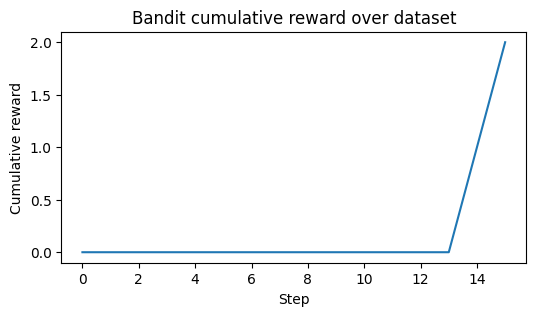

In [107]:
plt.figure(figsize=(6, 3))
plt.plot(bandit_df["step"], bandit_df["cum_reward"])
plt.xlabel("Step")
plt.ylabel("Cumulative reward")
plt.title("Bandit cumulative reward over dataset")
plt.show()


In [108]:
""" Rolling average reward"""

' Rolling average reward'

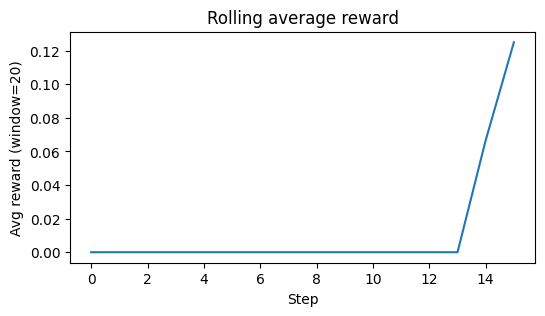

In [109]:
window = 20  # steps
rolling = bandit_df["reward"].rolling(window, min_periods=1).mean()

plt.figure(figsize=(6, 3))
plt.plot(bandit_df["step"], rolling)
plt.xlabel("Step")
plt.ylabel(f"Avg reward (window={window})")
plt.title("Rolling average reward")
plt.show()


In [110]:
"""Action distribution overall"""

'Action distribution overall'

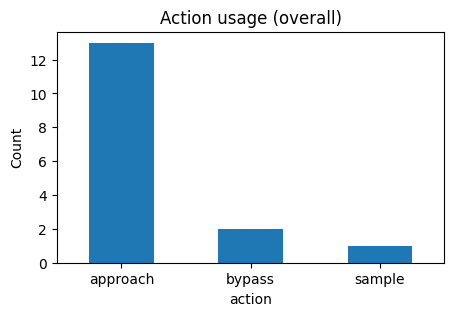

In [111]:
action_counts = bandit_df["action"].value_counts().reindex(ACTIONS, fill_value=0)

plt.figure(figsize=(5, 3))
action_counts.plot(kind="bar")
plt.xticks(rotation=0)
plt.ylabel("Count")
plt.title("Action usage (overall)")
plt.show()


In [35]:
"""Action choice conditioned on ground truth"""

'Action choice conditioned on ground truth'

action    approach  bypass  sample
gt_clean                          
False            5       2       1
True             8       0       0


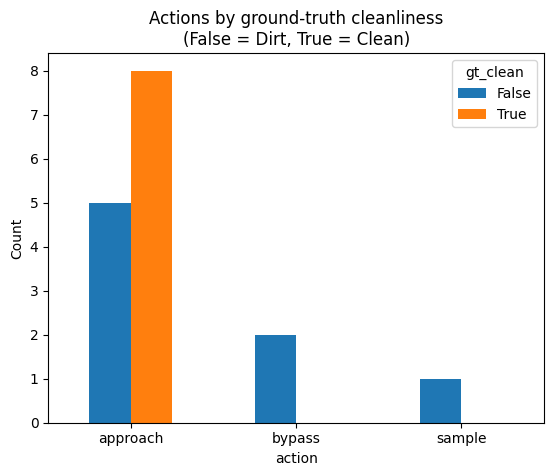

In [112]:
# counts of actions when patch is actually clean vs dirty
by_gt = (
    bandit_df
      .groupby(["gt_clean", "action"])["step"]
      .count()
      .unstack(fill_value=0)
)

print(by_gt)

by_gt.T.plot(kind="bar")
plt.xticks(rotation=0)
plt.ylabel("Count")
plt.title("Actions by ground-truth cleanliness\n(False = Dirt, True = Clean)")
plt.show()


In [113]:
"""Online policy wrapper (for ROS loop)"""

'Online policy wrapper (for ROS loop)'

In [114]:
def decide_action(image_path, distance_m, model=sand_model, bandit=bandit):
    """
    Online policy for the rover.

    image_path : path to current camera frame (or saved patch)
    distance_m : distance from rover to this patch (from pose / LiDAR)

    Returns a dict with the classifier output + chosen action.
    """
    # classify patch (Clean vs Dirt)
    res = model.predict(image_path, imgsz=224, verbose=False)[0]
    probs = res.probs
    cid = int(probs.top1)
    cls_name = res.names[cid]
    cls_conf = float(probs.top1conf)

    # build feature vector for bandit
    x = make_features(cls_name, cls_conf, distance_m, class_to_id)

    # choose action
    a = bandit.select(x)

    return {
        "pred_class": cls_name,          # e.g. "Clean" or "Dirt"
        "pred_conf": cls_conf,          # probability for that class
        "pred_is_clean": is_valuable(cls_name),  # True if HARVESTABLE_CLASS
        "distance_m": distance_m,
        "action_id": a,
        "action": ACTIONS[a]
    }



In [115]:
from random import choice

all_imgs = list((SAND_DATA / "images" / SPLIT).rglob("*.*"))
example_img = choice(all_imgs)

print(decide_action(str(example_img), 1.3))


{'pred_class': 'Clean', 'pred_conf': 0.9997639060020447, 'pred_is_clean': True, 'distance_m': 1.3, 'action_id': 1, 'action': 'bypass'}


{'pred_class': 'Clean', 'pred_conf': 0.9905417561531067, 'pred_is_clean': True, 'distance_m': 1.3, 'action_id': 1, 'action': 'bypass'}


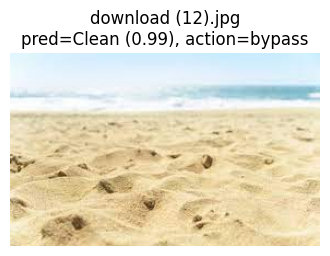

In [116]:
from pathlib import Path
from random import choice
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

# pick an example image (here: from the Clean class in the chosen SPLIT)
example_img = next((SAND_DATA / "images" / SPLIT / HARVESTABLE_CLASS).glob("*.*"))
# or: example_img = choice(list((SAND_DATA / "images" / SPLIT).rglob("*.*")))

result = decide_action(str(example_img), distance_m=1.3)
print(result)

# display the image with the chosen action in the title
img = Image.open(example_img)
plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.axis("off")
plt.title(f"{example_img.name}\npred={result['pred_class']} "
          f"({result['pred_conf']:.2f}), action={result['action']}")
plt.show()
